## Import Library

In [6]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, QuantileTransformer, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [8]:
# Fungsi untuk mencetak judul agar tampilan lebih rapi
def print_heading(heading):
    print('-' * 50)
    print(heading)
    print('-' * 50)

## Data Understanding

In [9]:
# Membaca file CSV dan menampilkan 5 baris pertama DataFrame
df = pd.read_csv('heart_disease_uci.csv')
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [14]:
# Mengecek dimensi (bentuk) data, yaitu baris dan kolom
df.shape
print(f"Row = {df.shape[0]} \nColumn = {df.shape[1]}")

Row = 920 
Column = 16


In [15]:
# Menampilkan ringkasan informasi dataset (tipe data, jumlah data yang tidak kosong)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


In [ ]:
# Menampilkan statistik untuk kolom numerik
df.describe()

,id,age,trestbps,chol,thalch,oldpeak,ca,num
count,920.000000,920.000000,861.000000,890.000000,865.000000,858.000000,309.000000,920.000000
mean,460.500000,53.510870,132.132404,199.130337,137.545665,0.878788,0.676375,0.995652
std,265.725422,9.424685,19.066070,110.780810,25.926276,1.091226,0.935653,1.142693
min,1.000000,28.000000,0.000000,0.000000,60.000000,-2.600000,0.000000,0.000000
25%,230.750000,47.000000,120.000000,175.000000,120.000000,0.000000,0.000000,0.000000
50%,460.500000,54.000000,130.000000,223.000000,140.000000,0.500000,0.000000,1.000000
75%,690.250000,60.000000,140.000000,268.000000,157.000000,1.500000,1.000000,2.000000
max,920.000000,77.000000,200.000000,603.000000,202.000000,6.200000,3.000000,4.000000


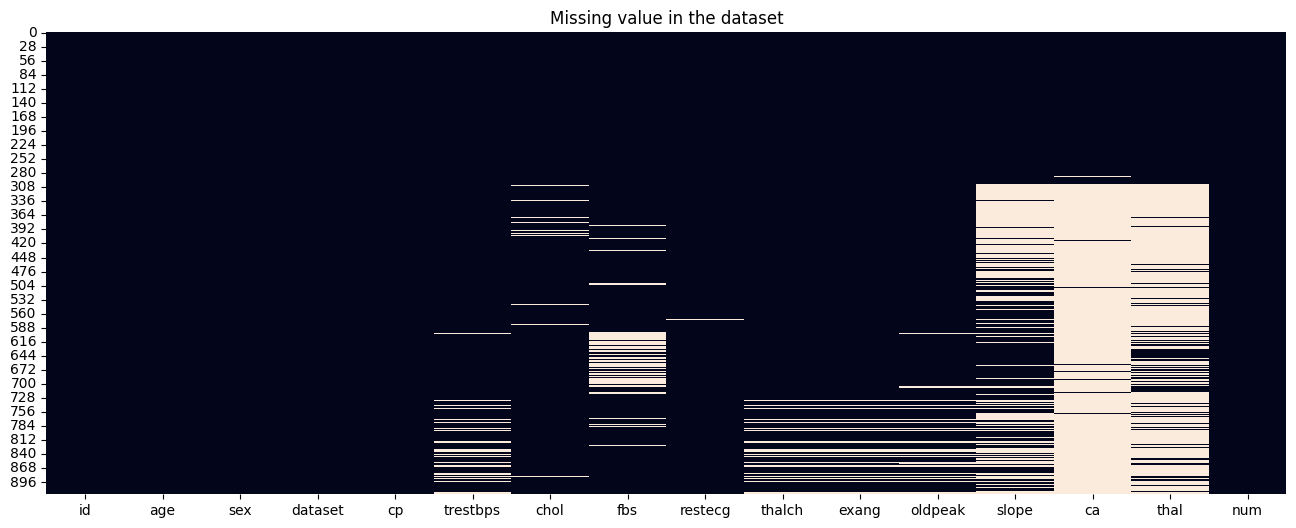

In [ ]:
# Membuat visualisasi heatmap untuk mendeteksi missing value
plt.figure(figsize=(16, 6))
sns.heatmap(df.isnull(), cbar=False)
plt.title('Missing value in the dataset')
plt.show()

In [17]:
# Menghitung persentase missing value, kemudian hasilnya diurutkan dari yang terbesar ke terkecil (descending)
round(((df.isnull().sum() / len(df)) * 100).sort_values(ascending=False),2)

ca          66.41
thal        52.83
slope       33.59
fbs          9.78
oldpeak      6.74
trestbps     6.41
exang        5.98
thalch       5.98
chol         3.26
restecg      0.22
cp           0.00
dataset      0.00
id           0.00
age          0.00
sex          0.00
num          0.00
dtype: float64

## Data Preparation

In [22]:
# Mencari kolom numerikal dan kategorikal secara otomatis dengan nilai missing value di bawah 10%
missing_threshold = 10  # 10% threshold untuk missing value
total_entries = len(df)
target_variable = 'num'

# Daftar kolom numerikal yang mempunyai nilai threshold missing value di bawah 10% dan bukan variable target
numerical_cols = [col for col in df.columns
                    if (
                        (df[col].dtype in ['int64', 'float64']) and
                        (df[col].isnull().sum() / total_entries * 100) < missing_threshold and
                        col != target_variable
                    )
                ]

# Daftar kolom kategorikal yang mempunyai nilai threshold missing value di bawah 10%
categorical_cols = [col for col in df.columns
                        if (
                            (df[col].dtype == 'object') and
                            (df[col].isnull().sum() / total_entries * 100) < missing_threshold
                        )
                    ]

# Inisialisasi imputer (pengisi missing value) untuk kolom numerikal dan kategorikal
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

# Mengisi imputasi untuk kolom numerikal dan kategorikal
for col in numerical_cols:
    df.loc[:,col] = num_imputer.fit_transform(df[[col]])

for col in categorical_cols:
    df.loc[:, col] = cat_imputer.fit_transform(df[[col]])

print_heading('Hasil setelah Imputasi')

# Memastikan tidak ada lagi missing value di kolom-kolom selain 'thal', 'ca', dan 'slope'
missing_values_sum = df[df.columns.difference(['thal', 'ca', 'slope'])].isnull().sum()
print(f"{missing_values_sum}"  + "\n")

print_heading('Fitur dengan nilai missing value tinggi')
print(f"{df[['thal', 'ca', 'slope']].isnull().sum()}")

--------------------------------------------------
Hasil setelah Imputasi
--------------------------------------------------
age         0
chol        0
cp          0
dataset     0
exang       0
fbs         0
id          0
num         0
oldpeak     0
restecg     0
sex         0
thalch      0
trestbps    0
dtype: int64

--------------------------------------------------
Fitur dengan nilai missing value tinggi
--------------------------------------------------
thal     486
ca       611
slope    309
dtype: int64


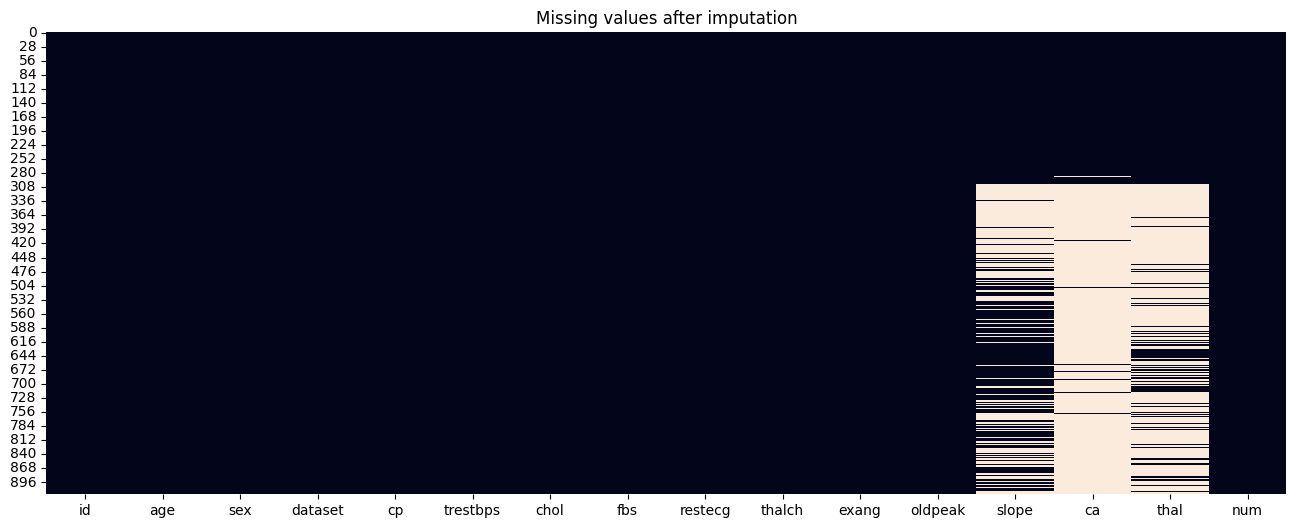

In [23]:
# Membuat visualisasi heatmap untuk mendeteksi missing values setelah imputasi
plt.figure(figsize=(16, 6))
sns.heatmap(df.isnull(), cbar=False)
plt.title('Missing values after imputation')
plt.show()

In [24]:
# Membagi dataset menjadi dua bagian (data yang sudah lengkap dan data yang masih memiliki nilai kosong)
df_clean = df.dropna()
df_missing = df[df.isna().any(axis=1)]

print_heading('Data yang tidak mempunyai missing value'.upper())
print(f"Data yang sudah lengkap: {df_clean.shape}")
print("\n")
print_heading('Data yang mempunyai missing value'.upper())
print(f"Data dengan missing value: {df_missing.shape}")

--------------------------------------------------
DATA YANG TIDAK MEMPUNYAI MISSING VALUE
--------------------------------------------------
Data yang sudah lengkap: (299, 16)


--------------------------------------------------
DATA YANG MEMPUNYAI MISSING VALUE
--------------------------------------------------
Data dengan missing value: (621, 16)


In [28]:
# Melatih dan mengevaluasi model untuk variabel target 'slope', 'thanl', dan 'ca'.
def predict_and_evaluate(target_variable, drop_columns):
    # 1. Menyiapkan fitur (x)
    X = df_clean.drop(drop_columns, axis=1)

    # 2. Menyiapkan fitur (y)
    y = df_clean[target_variable]

    # 3. Encoding fitur kategorikal
    le = LabelEncoder()
    for col in X.columns:
        if X[col].dtype == 'object':
            X[col] = le.fit_transform(X[col])

    # 4. Membagi data latih dan data uji
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 5. Melatih model
    model = RandomForestClassifier(n_estimators=10, random_state=42)
    model.fit(X_train, y_train)

    # 6. Evaluasi model
    y_pred = model.predict(X_test)
    print_heading(f'Model performance for {target_variable}'.upper())
    print(f"The accuracy of the model is: {round(accuracy_score(y_test, y_pred),2)}")
    print(f"Classification report:\n {classification_report(y_test, y_pred)}")
    
    return model

In [29]:
# Memanggil fungsi untuk memprediksi fitur 'slope' tanpa 'slope', 'ca', 'thal'
rf_model_slope  = predict_and_evaluate('slope', ['slope', 'ca', 'thal'])

--------------------------------------------------
MODEL PERFORMANCE FOR SLOPE
--------------------------------------------------
The accuracy of the model is: 0.72
Classification report:
               precision    recall  f1-score   support

 downsloping       0.00      0.00      0.00         3
        flat       0.70      0.76      0.73        25
   upsloping       0.75      0.75      0.75        32

    accuracy                           0.72        60
   macro avg       0.48      0.50      0.49        60
weighted avg       0.69      0.72      0.70        60



In [30]:
# Memanggil fungsi untuk memprediksi fitur 'ca' tanpa 'ca', 'thal'
rf_model_ca = predict_and_evaluate('ca', [ 'ca', 'thal'])

--------------------------------------------------
MODEL PERFORMANCE FOR CA
--------------------------------------------------
The accuracy of the model is: 0.72
Classification report:
               precision    recall  f1-score   support

         0.0       0.76      0.97      0.86        40
         1.0       0.67      0.15      0.25        13
         2.0       0.33      0.40      0.36         5
         3.0       0.00      0.00      0.00         2

    accuracy                           0.72        60
   macro avg       0.44      0.38      0.37        60
weighted avg       0.68      0.72      0.66        60



In [31]:
# Memanggil fungsi untuk memprediksi fitur 'slope' tanpa 'thal'
rf_model_thal = predict_and_evaluate('thal', ['thal'])

--------------------------------------------------
MODEL PERFORMANCE FOR THAL
--------------------------------------------------
The accuracy of the model is: 0.7
Classification report:
                    precision    recall  f1-score   support

     fixed defect       0.00      0.00      0.00         4
           normal       0.67      0.94      0.78        31
reversable defect       0.76      0.52      0.62        25

         accuracy                           0.70        60
        macro avg       0.48      0.49      0.47        60
     weighted avg       0.67      0.70      0.66        60



In [22]:
# create a new dataframe and drop the target variables
df_encoded_pred = df_missing.drop(['slope', 'ca', 'thal'], axis=1)

# Encode categorical features and predict the missing values
def encode_and_predict(df, target_variable, model):

    # Initialize label encoder
    le = LabelEncoder()

    # Loop through each column in the DataFrame
    for col in df.columns:
        # Check if the column is of type 'object' (categorical)
        if df[col].dtype == 'object':
            # encode the categorical data to integers
            df[col] = le.fit_transform(df[col])
    # Use the model to apply predictions and assign the predicted values to the target variable
    df[target_variable] = model.predict(df)

# Encode categorical features and predict the 'slope' column in df_encoded_pred
encode_and_predict(df_encoded_pred, 'slope', rf_model_slope)
# Update the 'slope' column in df_missing with the predicted values
df_missing.loc[:,'slope'] = df_encoded_pred['slope']

In [23]:
# Create a new dataframe and drop the target variables
df_encoded_pred = df_missing.drop(['ca', 'thal'], axis=1)
# Encode categorical features and predict the 'ca' column in df_encoded_pred
encode_and_predict(df_encoded_pred, 'ca', rf_model_ca)
# Update the 'ca' column in df_missing with the predicted values
df_missing.loc[:, 'ca'] = df_encoded_pred['ca']

In [24]:
# Create a new dataframe and drop the target variables
df_encoded_pred = df_missing.drop(['thal'], axis=1)
# Encode categorical features and predict the 'thal' column in df_encoded_pred
encode_and_predict(df_encoded_pred, 'thal', rf_model_thal)
# Update the 'thal' column in df_missing with the predicted values
df_missing.loc[:, 'thal'] = df_encoded_pred['thal']

In [25]:
# merge df_clean and df_missing
df = pd.concat([df_clean, df_missing])

print_heading('Dataset shape inspect'.upper())
print(f"The shape of the dataset is: {df.shape[0]} rows and {df.shape[1]} columns.")

--------------------------------------------------
DATASET SHAPE INSPECT
--------------------------------------------------
The shape of the dataset is: 920 rows and 16 columns.


In [26]:
# Display the missing values if any in the dataset for verification
print_heading('Missing values inspect'.upper())
if df.isnull().sum().sum() == 0:
    print("There are no missing values in the dataset.")
else:
    print("There are missing values in the dataset.")

--------------------------------------------------
MISSING VALUES INSPECT
--------------------------------------------------
There are no missing values in the dataset.


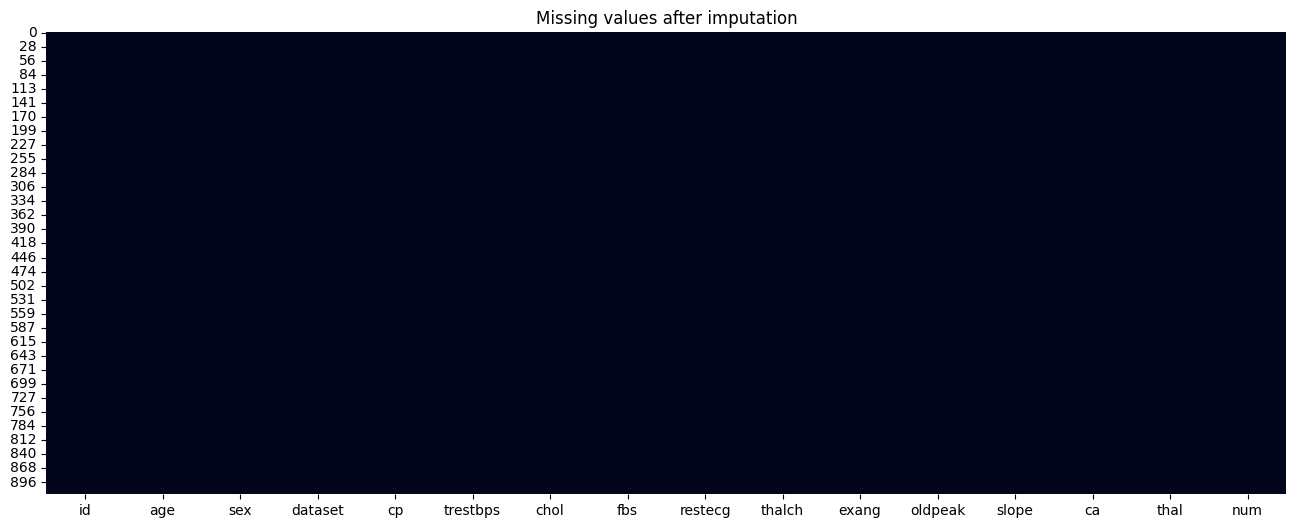

In [27]:
# create a heatmap for df to check missing values
plt.figure(figsize=(16, 6))
sns.heatmap(df.isnull(), cbar=False)
plt.title('Missing values after imputation')
plt.show()

## Data Preparation Lanjutan (Scaling & Outliers)

In [28]:
# Plotting the histogram and boxplot to check the data distribution for the numerical columns
def plot_histogram_and_boxplot(df, numerical_cols, cyan_palette=["#00FFFF"]):
    # Set to "dark" for a black background
    sns.set(style="dark", palette="deep")

    # Set the figure size to accommodate the subplots
    plt.figure(figsize=(15, len(numerical_cols) * 5))

    # Loop through each numerical column and create a row with a histogram and a boxplot
    for i, col in enumerate(numerical_cols):
        # Histogram (left)
        ax1 = plt.subplot(len(numerical_cols), 2, 2*i + 1)
        sns.histplot(df[col], kde=True, bins=30, color=cyan_palette[0])
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        ax1.set_facecolor('#000133')

        # Boxplot (right)
        ax2 = plt.subplot(len(numerical_cols), 2, 2*i + 2)
        sns.boxplot(x=df[col], color=cyan_palette[0], linewidth=2.5,
                    flierprops=dict(markerfacecolor='w', marker='o', markeredgecolor='w', markersize=5),
                    whiskerprops=dict(color='white', linewidth=2.5),
                    capprops=dict(color='white', linewidth=2.5),
                    boxprops=dict(edgecolor='white', linewidth=2.5))
        plt.title(f'Boxplot of {col}')
        ax2.set_facecolor('#000133')

    # Adjust layout for better readability and display the plot
    plt.tight_layout()
    plt.show()

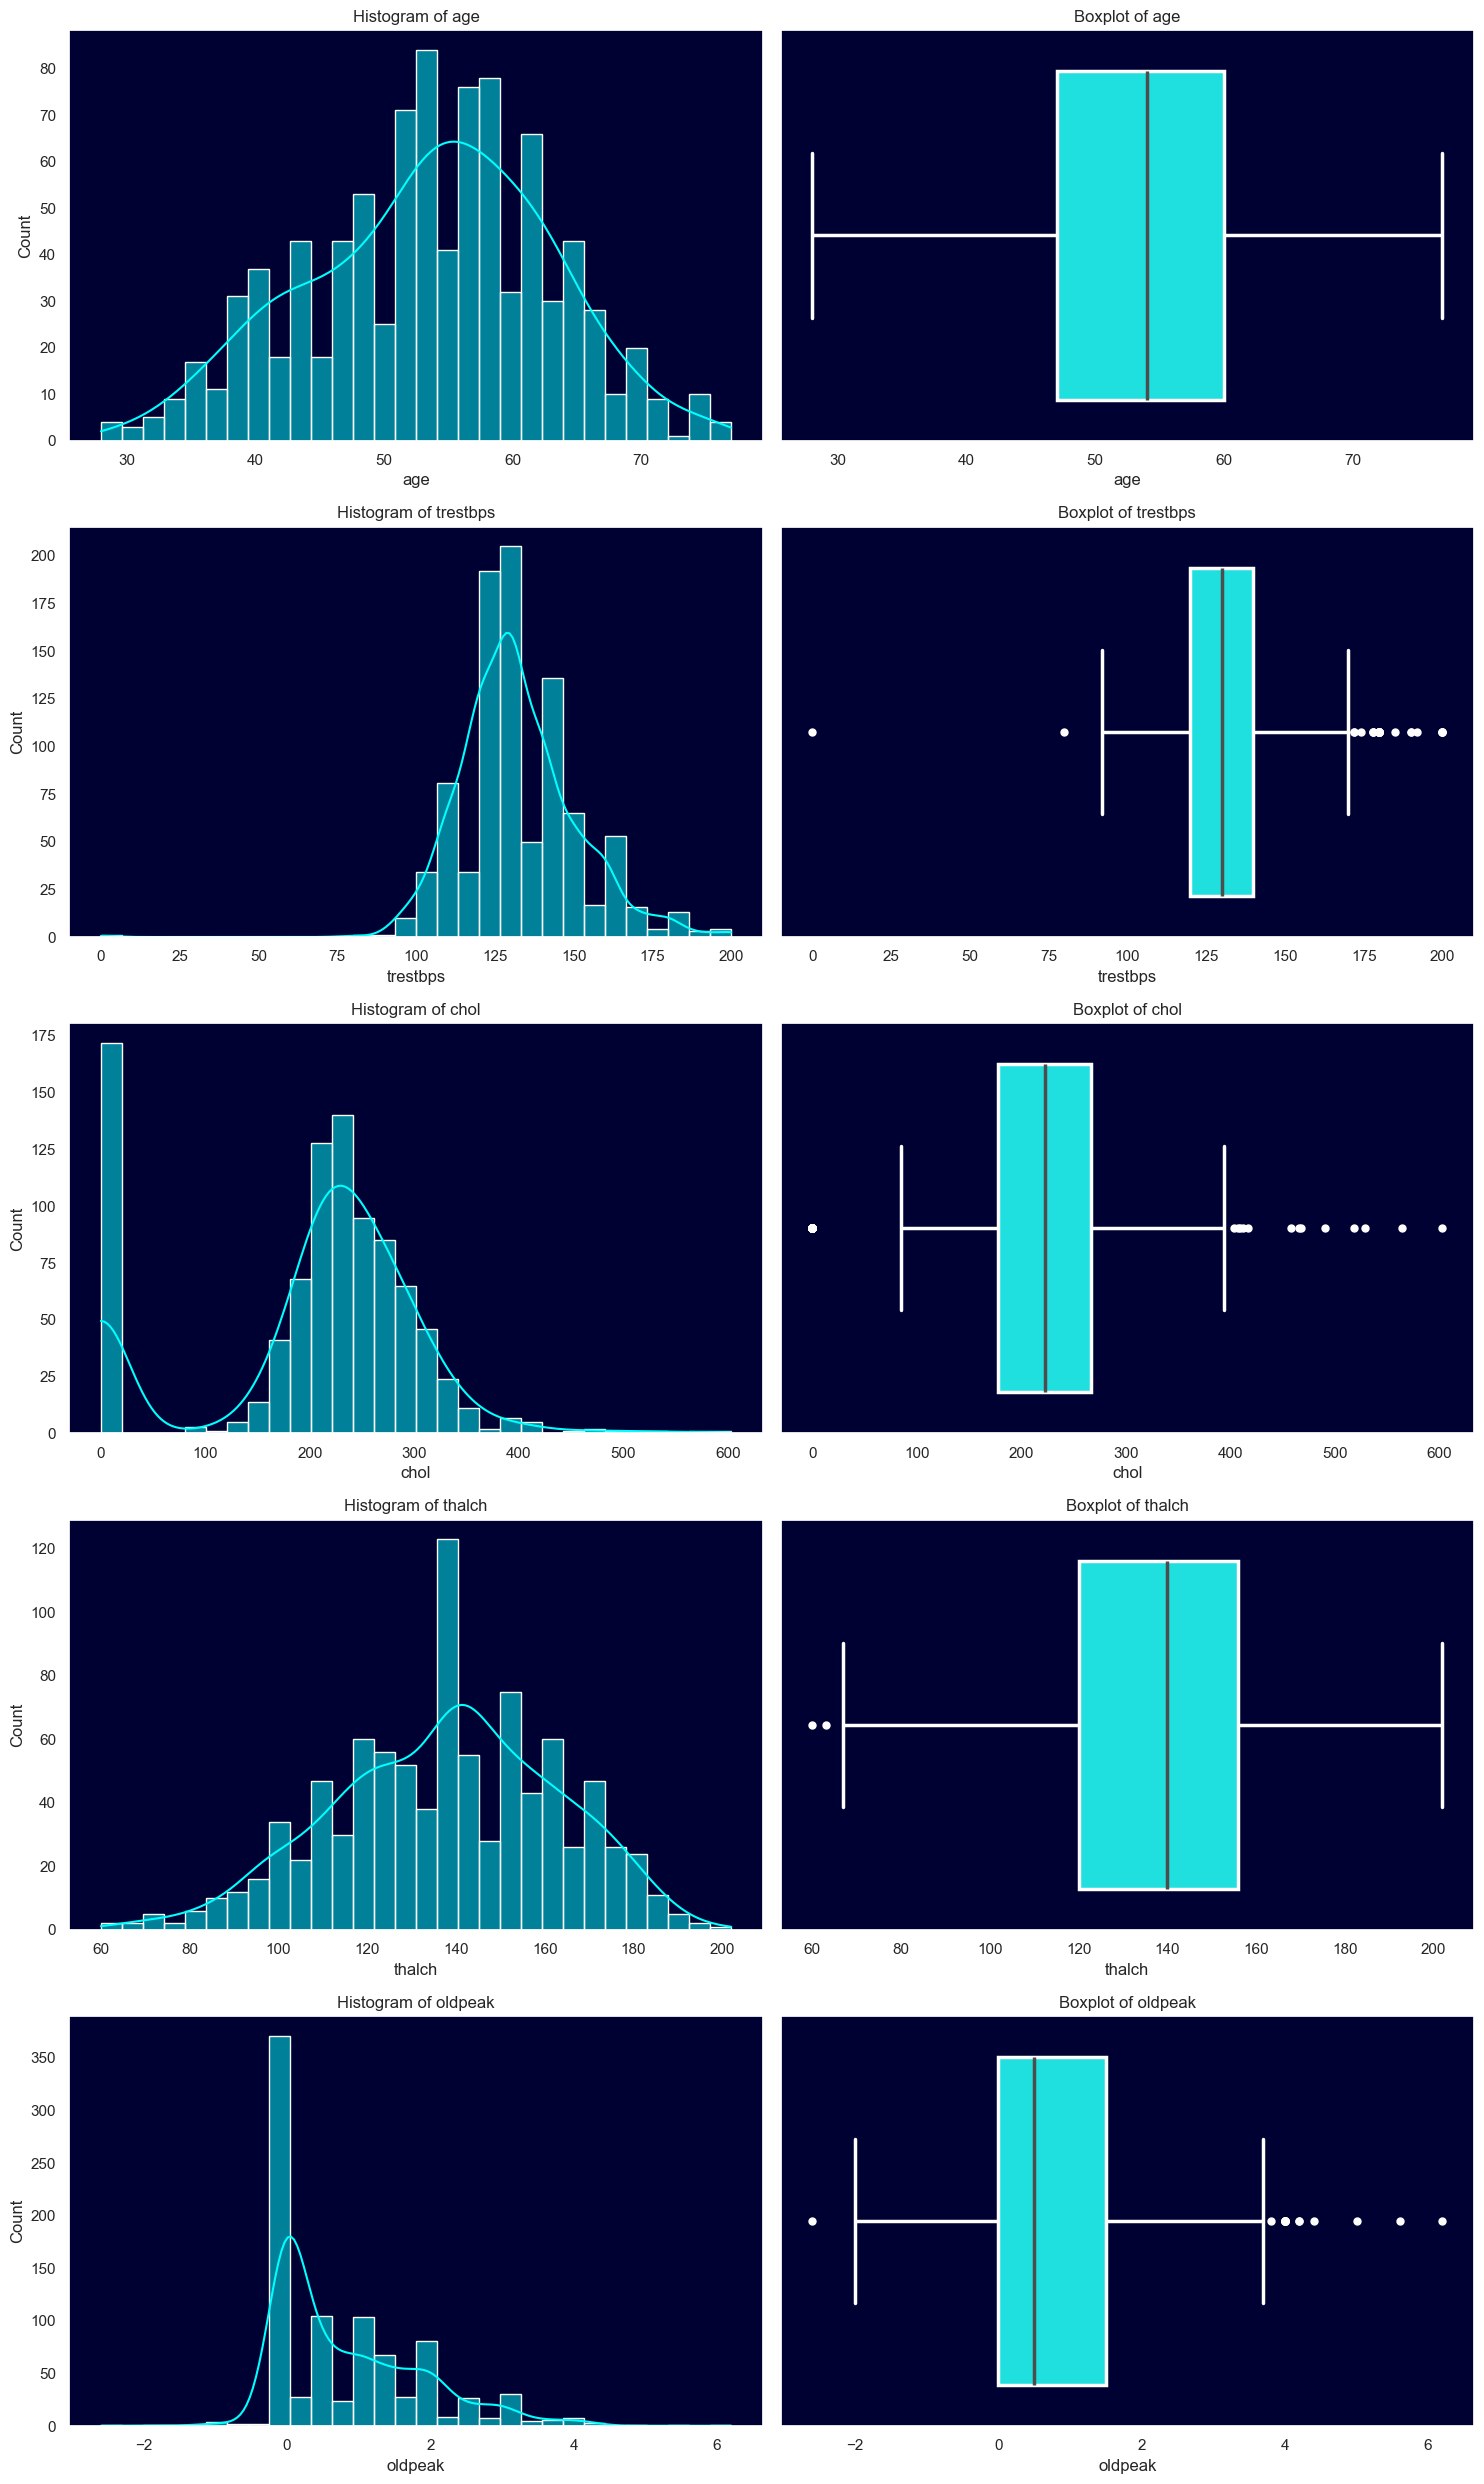

In [29]:
# Remove id column from numerical_cols
numerical_cols.remove('id')
# Plot histogram and boxplot for numerical columns before scaling
plot_histogram_and_boxplot(df, numerical_cols)

In [30]:
# Instantiate the QuantileTransformer with a normal output distribution and a fixed random state for reproducibility
quantile_transformer = QuantileTransformer(random_state=42, output_distribution='normal')

# Apply the transformer to the numerical columns of the DataFrame
df[numerical_cols] = quantile_transformer.fit_transform(df[numerical_cols])

In [31]:
# Calculate quantile ranges for each numerical column
def calc_lower_upper_bounds(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate the lower and upper bound for outliers which is 1.5 times the IQR less than the first and third quartile
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return lower_bound, upper_bound

# Detect outliers based on the IQR
def detect_outliers(df, column):

    lower_bound, upper_bound = calc_lower_upper_bounds(df, column)
    # Detect outliers based on the lower and upper bounds
    outliers_detected = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    #calculate the percentage of outliers in the dataset
    outliers_percentage = round(len(outliers_detected) / df[column].shape[0] * 100, 2)
    print(f"Number of outliers detected in {column}: {outliers_percentage}%")

# Remove outliers based on the IQR
def remove_outliers(df, column):

    lower_bound, upper_bound = calc_lower_upper_bounds(df, column)
    # Remove outliers from the dataframe
    df_no_outliers = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_no_outliers

# Disaplay heading
print_heading(f"percentages of outliers detected".upper())

# Detect and remove outliers for the numerical column
for col in numerical_cols:
    detect_outliers(df, col)
    # Only remove outliers for 'chol'
    if col in ['chol']:
        df = remove_outliers(df, col)

--------------------------------------------------
PERCENTAGES OF OUTLIERS DETECTED
--------------------------------------------------
Number of outliers detected in age: 0.87%
Number of outliers detected in trestbps: 1.3%
Number of outliers detected in chol: 19.13%
Number of outliers detected in thalch: 0.67%
Number of outliers detected in oldpeak: 0.27%


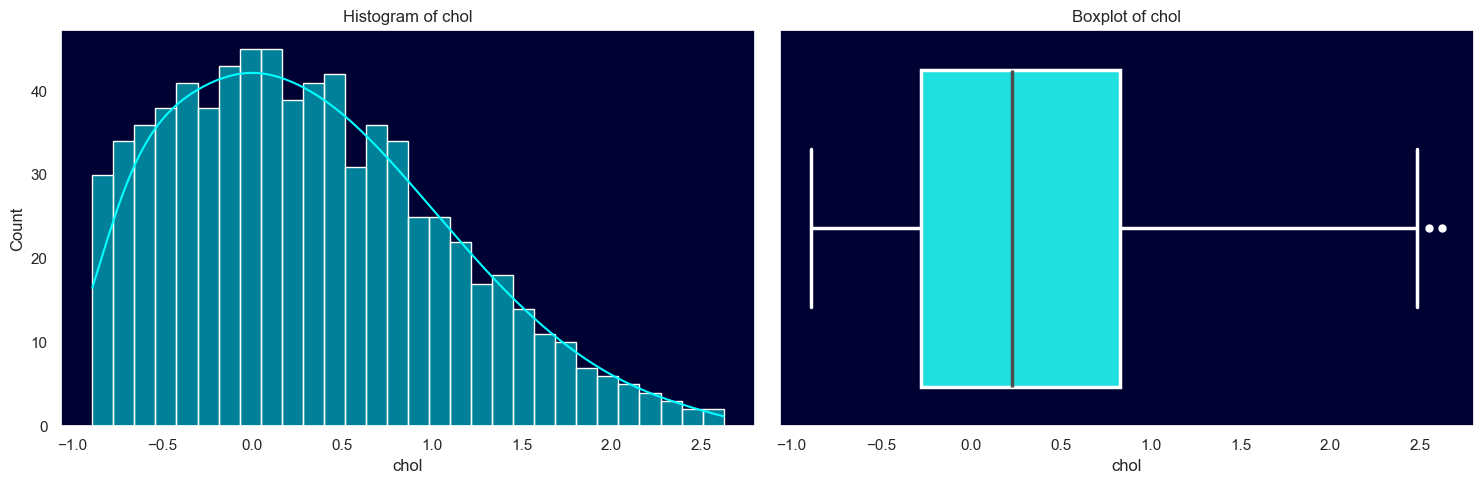

In [32]:
# Plot histogram and boxplot for numerical columns after removing outliers
plot_histogram_and_boxplot(df, ['chol'])

## Modeling & Evaluasi

In [33]:
# Drop the target column 'num' from the DataFrame to create the features dataset
X = df.drop('num', axis=1)

# Create the target dataset
y = df['num']

# Initialize LabelEncoder
le = LabelEncoder()
for col in X.columns:
    # If column is of object type
    if X[col].dtype == 'object':
        # Encode the column to convert categorical variables into numerical
        X[col] = le.fit_transform(X[col])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier model
rf_model = RandomForestClassifier(n_estimators=10, max_depth=10, random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Use the trained model to predict the target variable for the testing data
y_pred = rf_model.predict(X_test)

# Compute the confusion matrix to evaluate the accuracy of a classification
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix, accuracy of the model and the classification report
print_heading('Model performance'.upper())
print(f"The confusion matrix is:\n {confusion_matrix(y_test, y_pred)}")
print(f"\nThe accuracy of the model is: {round(accuracy_score(y_test, y_pred),2)}")
print(f"Classification report:\n {classification_report(y_test, y_pred)}")

--------------------------------------------------
MODEL PERFORMANCE
--------------------------------------------------
The confusion matrix is:
 [[78 10  0  0  0]
 [ 8 24  2  5  0]
 [ 0  3  7  0  0]
 [ 3  2  1  4  0]
 [ 0  0  1  1  0]]

The accuracy of the model is: 0.76
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.89      0.88        88
           1       0.62      0.62      0.62        39
           2       0.64      0.70      0.67        10
           3       0.40      0.40      0.40        10
           4       0.00      0.00      0.00         2

    accuracy                           0.76       149
   macro avg       0.51      0.52      0.51       149
weighted avg       0.75      0.76      0.75       149



## Confusion Matrix

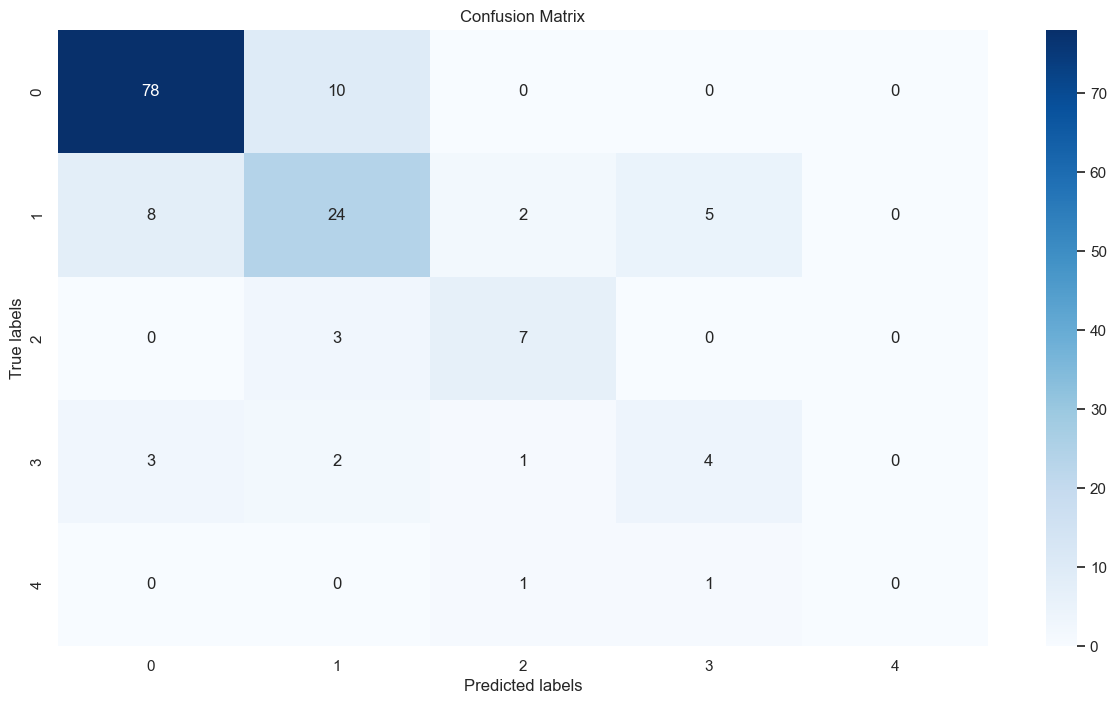

In [34]:
# Create a heatmap from the confusion matrix
plt.figure(figsize=(15, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

# Adding labels to the heatmap
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()